<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/LQG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are

# Time step and system dynamics
h = 0.1
A = np.array([[1, h], [0, 1]])
B = np.array([[0.5 * h ** 2], [h]])
C = np.array([[1.0, 0]])

# Noise covariances
W = B @ (0.1 * B.T)  # Process noise covariance
V = 0.1  # Measurement noise covariance (scalar)

# Dimensions and time
n = 2
m = 1
Tfinal = 10.0
N = int(Tfinal / h) + 1

# LQR weights
Q = np.eye(n)
R = 0.1 * np.eye(m)
Qn = Q

# Solve DARE and get LQR gain
P = solve_discrete_are(A, B, Q, R)
K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

# Initial true and estimated states
x0 = np.array([1.0, 0.0])
x_hat0 = np.array([0.0, 0.0])
Sigma0 = np.eye(n)

# Allocate history arrays
xhist = np.zeros((n, N))
xhist[:, 0] = x0
xhat_hist = np.zeros((n, N))
Sigma_hist = np.zeros((n, n, N))
yhist = np.zeros(N)
uhist = np.zeros(N)

# Initial measurement
yhist[0] = C @ xhist[:, 0] + np.sqrt(V) * np.random.randn()
z = yhist[0] - C @ x_hat0
S = C @ Sigma0 @ C.T + V
L = Sigma0 @ C.T @ np.linalg.inv(S)
xhat_hist[:, 0] = x_hat0 + (L @ z).flatten()
Sigma_hist[:, :, 0] = (np.eye(n) - L @ C) @ Sigma0 @ (np.eye(n) - L @ C).T + L * V @ L.T

uhist[0] = -K @ xhat_hist[:, 0]
xhist[:, 1] = A @ xhist[:, 0] + B.flatten() * uhist[0] + np.sqrt(W) @ np.random.randn(n)

# Main loop
for k in range(1, N - 1):
    yhist[k] = C @ xhist[:, k] + np.sqrt(V) * np.random.randn()

    # KF predict
    x_pred = A @ xhat_hist[:, k - 1] + B.flatten() * uhist[k - 1]
    Sigma_pred = A @ Sigma_hist[:, :, k - 1] @ A.T + W

    # KF update
    z = yhist[k] - C @ x_pred
    S = C @ Sigma_pred @ C.T + V
    L = Sigma_pred @ C.T @ np.linalg.inv(S)

    xhat_hist[:, k] = x_pred + (L @ z).flatten()
    Sigma_hist[:, :, k] = (
        (np.eye(n) - L @ C) @ Sigma_pred @ (np.eye(n) - L @ C).T + L * V @ L.T
    )

    # LQR control
    uhist[k] = -K @ xhat_hist[:, k]
    xhist[:, k + 1] = (
        A @ xhist[:, k] + B.flatten() * uhist[k] + np.sqrt(W) @ np.random.randn(n)
    )

<ipython-input-2-3947882234>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhist[0] = C @ xhist[:, 0] + np.sqrt(V) * np.random.randn()
<ipython-input-2-3947882234>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uhist[0] = -K @ xhat_hist[:, 0]
<ipython-input-2-3947882234>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhist[k] = C @ xhist[:, k] + np.sqrt(V) * np.random.randn()
<ipython-input-2-3947882234>:73: DeprecationWarning: Conversion of an array with

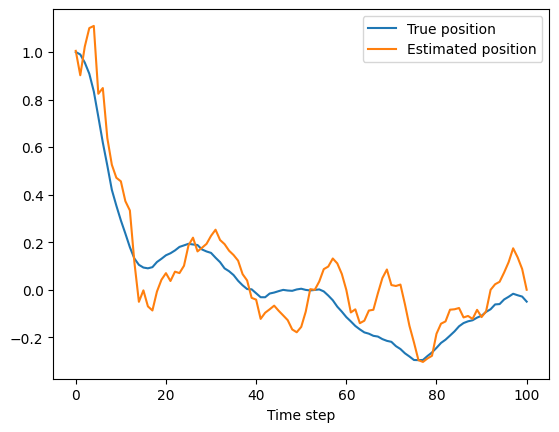

In [3]:
# Plotting state and estimate
plt.figure()
plt.plot(xhist[0, :], label="True position")
plt.plot(xhat_hist[0, :], label="Estimated position")
plt.xlabel("Time step")
plt.legend()

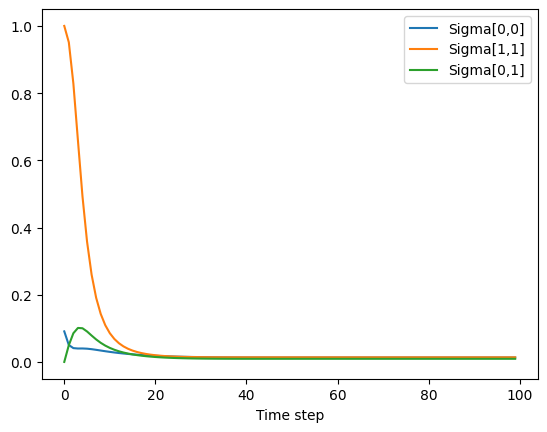

In [4]:
# Plotting covariance convergence
plt.figure()
plt.plot(Sigma_hist[0, 0, :-1], label="Sigma[0,0]")
plt.plot(Sigma_hist[1, 1, :-1], label="Sigma[1,1]")
plt.plot(Sigma_hist[0, 1, :-1], label="Sigma[0,1]")
plt.xlabel("Time step")
plt.legend()
plt.show()